In [1]:
%matplotlib notebook

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

/home/scratch/ms16cf/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/scratch/ms16cf/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


ImportError: No module named 'tensorflow'

In [2]:
# Print out some sample images

fig = plt.figure()
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(mnist.train.images[i].reshape(28, 28), cmap='Greys_r')  

<IPython.core.display.Javascript object>

### Initialisations

Let us write some helper functions to initialise weights and biases. We'll initialise weights as Gaussian random variables with mean 0 and variance 0.0025. For biases we'll initialise everything with a constant 0.1. This is because we're mainly going to be using ReLU non-linearities.

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

#-----------------------------------------------
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Stride (2,2), no padding
def conv2d_2x2_no_pad(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='VALID')

# Stride (2,1), with padding
def conv2d_2x1_pad(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 1, 1], padding='SAME')

# stide of 2
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#-----------------------------------------------



### Model

Let's define the model. The model is defined as follows:

* An input that is 728 dimensional vector. 
* Reshape the input as 28x28x1 images (only 1 because they are grey scale) 
* A convolutional layer with 25 filters of shape 12x12x1 and a ReLU non-linearity (with stride (2, 2) and no padding)
* A convolutional layer with 64 filters of shape 5x5x25 and a ReLU non-linearity (with stride (1, 2) and padding to maintain size)
* A max_pooling layer of shape 2x2
* A fully connected layer taking all the outputs of the max_pooling layer to 1024 units and ReLU nonlinearity
* A fully connected layer taking 1024 units to 10 no activation function (the softmax non-linearity will be included in the loss function rather than in the model)

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 784])
# reshape x to a 4d tensor, 
# with the second and third dimensions corresponding to image width and height, 
# and the final dimension corresponding to the number of color channels.
x_image = tf.reshape(x, [-1, 28, 28, 1])

y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Define the first convolution layer here
# First two dimensions are the patch size, 
# then number of input channels, the num output channels
W_conv1 = weight_variable([12, 12, 1, 25])
# bias vector with a component for each output channel
b_conv1 = bias_variable([25])
# convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.
h_conv1 = tf.nn.relu(conv2d_2x2_no_pad(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


# Define the second convolution layer here
W_conv2 = weight_variable([5, 5, 25, 64])

b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d_2x1_pad(h_pool1, W_conv2) + b_conv2)

# Define maxpooling
h_pool2 = max_pool_2x2(h_conv2)

# All subsequent layers will be fully connected ignoring geometry so we'll flatten the layer
# Flatten the h_pool2_layer (as it has a multidimensiona shape) 
h_pool2_flat = tf.reshape(h_pool2, [-1, 2*3*64])


# Define the first fully connected layer here
# image of size 2 x 3. 2 =  28 / 2 (conv 2d no pad) / 2 (max pool) / 2 (pad = 4, conv 2x1 pad) / 2 (max pool 2x2) = 2
# image of size 2 x 3. 3 =  28 / 2 (conv 2d no pad) / 2 (max pool) / 1 (pad = 8, conv 2x1 pad) / 2 (max pool 2x2) = 2

W_fc1 =  weight_variable([2 * 3 * 64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Use dropout for this layer (should you wish)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# The final fully connected layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#### Loss Function, Accuracy and Training Algorithm

* We'll use the cross entropy loss function. The loss function is called `tf.nn.cross_entropy_with_logits` in tensorflow

* Accuray is simply defined as the fraction of data correctly classified

* For training you should use the AdamOptimizer (read the documentation) and set the learning rate to be 1e-4. You are welcome, and in fact encouraged, to experiment with other optimisation procedures and learning rates. 

* (Optional): You may even want to use different filter sizes once you are finished with experimenting with what is asked in this practial

In [5]:
# We'll use the cross entropy loss function 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))

# And classification accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# And the Adam optimiser
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

In [6]:
# Load the mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
# Let us visualise the first 16 data points from the MNIST training data

fig = plt.figure()
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(mnist.train.images[i].reshape(28, 28), cmap='Greys_r')  

<IPython.core.display.Javascript object>

In [8]:
# Start a tf session and run the optimisation algorithm

sess = tf.Session()
with sess.as_default():
    sess.run(tf.initialize_all_variables())

    for i in range(2000):
        batch = mnist.train.next_batch(50)
        if i%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.14
step 100, training accuracy 0.64
step 200, training accuracy 0.92
step 300, training accuracy 0.84
step 400, training accuracy 0.92
step 500, training accuracy 0.82
step 600, training accuracy 0.96
step 700, training accuracy 0.94
step 800, training accuracy 0.84
step 900, training accuracy 0.98
step 1000, training accuracy 0.94
step 1100, training accuracy 0.92
step 1200, training accuracy 0.94
step 1300, training accuracy 0.94
step 1400, training accuracy 0.94
step 1500, training accuracy 0.92
step 1600, training accuracy 0.9
step 1700, training accuracy 0.96
step 1800, training accuracy 0.96
step 1900, training accuracy 0.94


In [9]:
# Print accuracy on the test set
print ('Test accuracy: %g' % sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Test accuracy: 0.9635


#### Visualising the Filters

We'll now visualise all the 32 filters in the first convolution layer. As they are each of shape 12x12x1, they may themselves be viewed as greyscale images. Visualising filters in further layers is more complicated and involves modifying the neural network. See the [paper](http://www.matthewzeiler.com/pubs/arxive2013/arxive2013.pdf) by Matt Zeiler and Rob Fergus if you are interested. 

(12, 12, 1, 25)


<IPython.core.display.Javascript object>


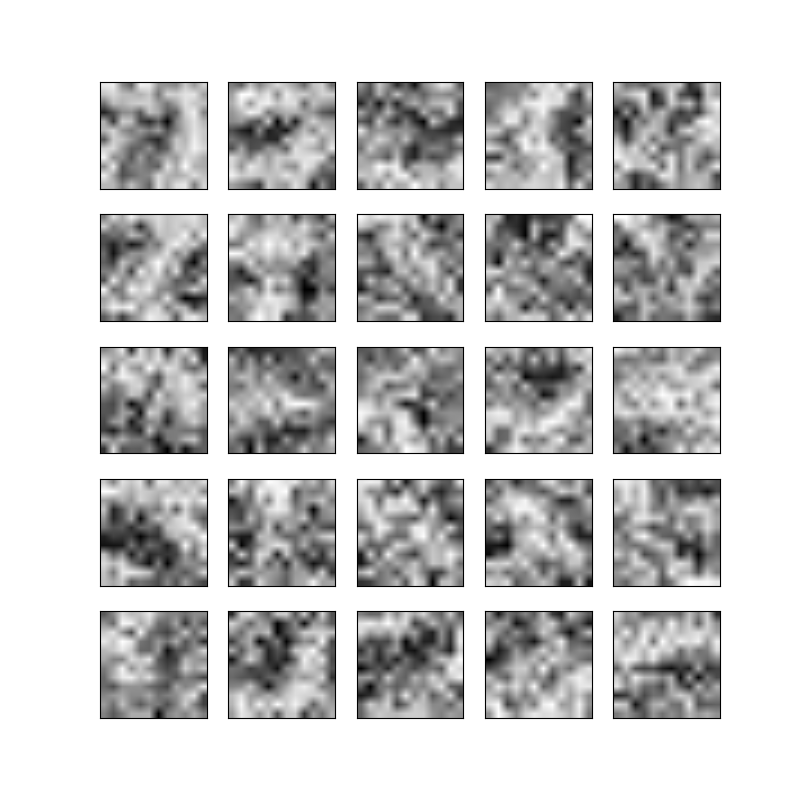

In [10]:


# Visualise the filters in the first convolutional layer
with sess.as_default():
    W = W_conv1.eval()
    print W.shape

    
    # Add code to visualise fitlers here
fig = plt.figure()
for i in range(25):
    #print W[:,:,0:i]
    ax = fig.add_subplot(5, 5, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(W[:,:,0,i], cmap='Greys_r') 

#### Identifying image patches that activate the filters

For this part you'll find the 12 patches in the test-set that activate each of the first 5 filters that maximise the activation for that filter.

In [11]:
H =  sess.run(h_conv1, feed_dict={x: mnist.test.images})

<IPython.core.display.Javascript object>


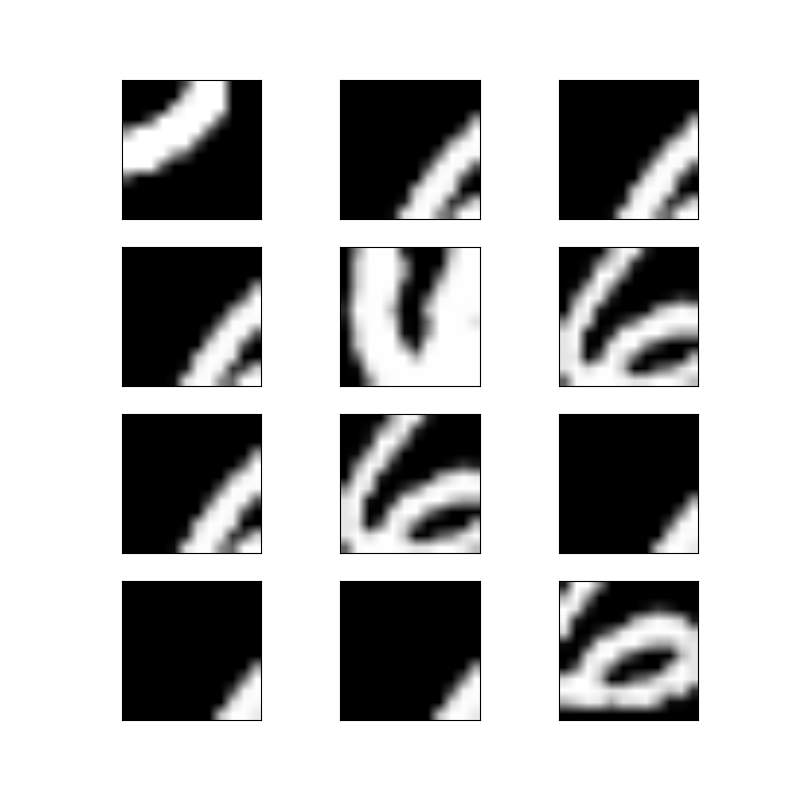

In [16]:
# Filter 1

fig = plt.figure()
H_filter = H[:,:,:,1]
H_sorted = np.argsort(H_filter,axis=None)
max12 = H_sorted[0:12]

for j in range(12):
    index = np.unravel_index(max12[j], H_filter.shape)
    im = mnist.test.images[index[0]].reshape(28,28)
    im = im[index[1]*2:index[1]*2+12,index[1]*2:index[1]*2+12]
    ax = fig.add_subplot(4, 3, j + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(im, cmap='Greys_r') 

<IPython.core.display.Javascript object>


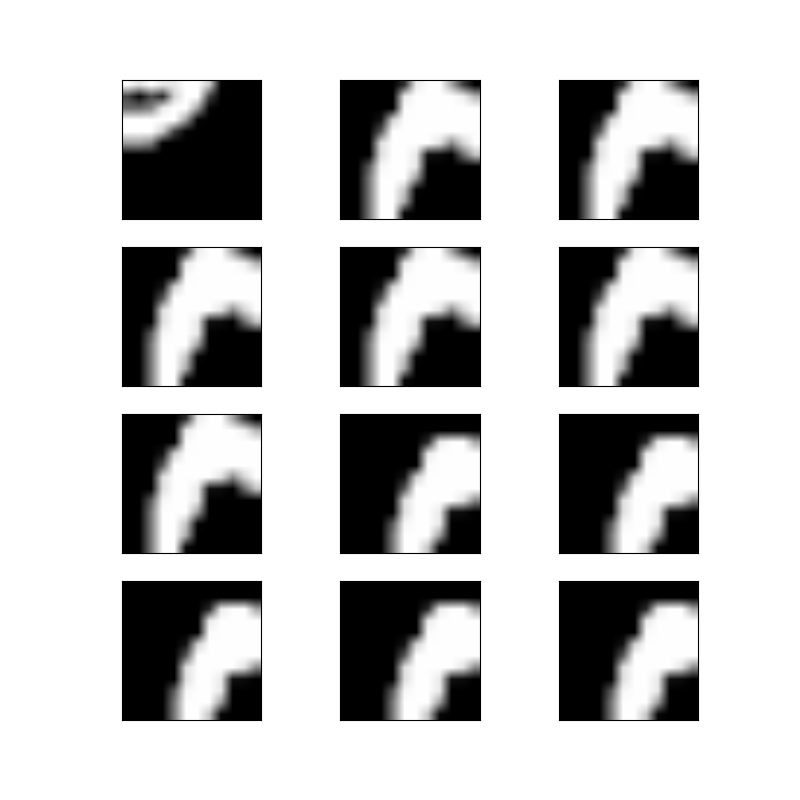

In [15]:
# Filter 2

fig = plt.figure()
H_filter = H[:,:,:,2]
H_sorted = np.argsort(H_filter,axis=None)
max12 = H_sorted[0:12]

for j in range(12):
    index = np.unravel_index(max12[j], H_filter.shape)
    im = mnist.test.images[index[0]].reshape(28,28)
    im = im[index[1]*2:index[1]*2+12,index[1]*2:index[1]*2+12]
    ax = fig.add_subplot(4, 3, j + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(im, cmap='Greys_r') 

<IPython.core.display.Javascript object>


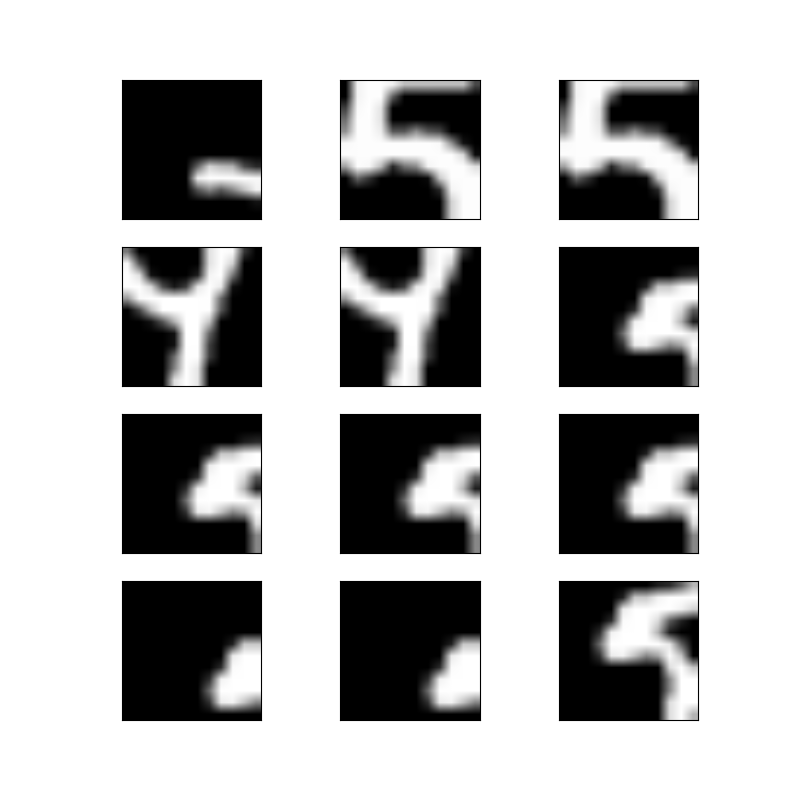

In [17]:
# Filter 3

fig = plt.figure()
H_filter = H[:,:,:,3]
H_sorted = np.argsort(H_filter,axis=None)
max12 = H_sorted[0:12]

for j in range(12):
    index = np.unravel_index(max12[j], H_filter.shape)
    im = mnist.test.images[index[0]].reshape(28,28)
    im = im[index[1]*2:index[1]*2+12,index[1]*2:index[1]*2+12]
    ax = fig.add_subplot(4, 3, j + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(im, cmap='Greys_r') 

<IPython.core.display.Javascript object>


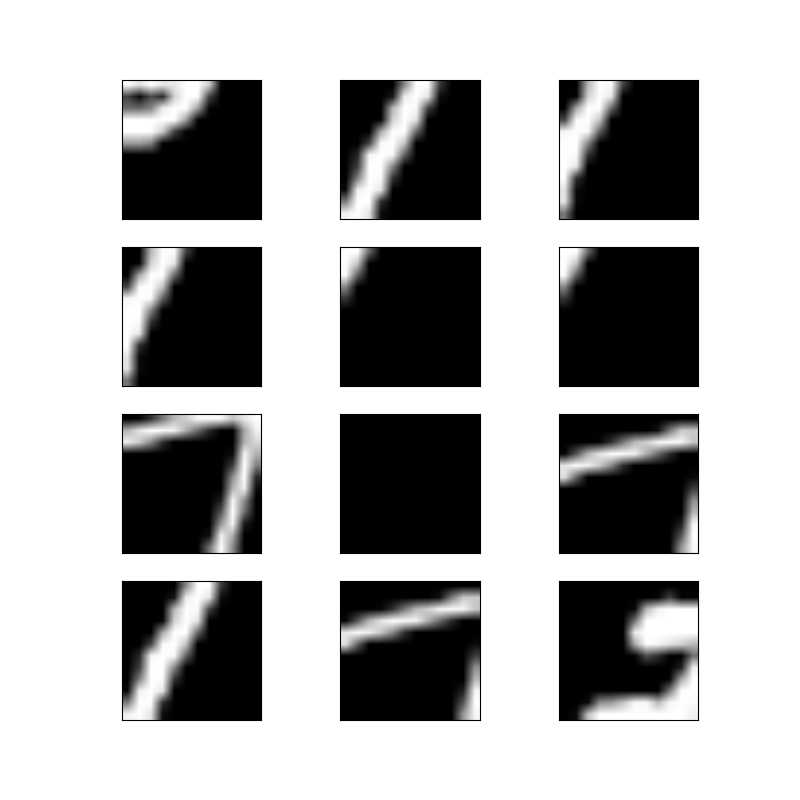

In [18]:
# Filter 4

fig = plt.figure()
H_filter = H[:,:,:,4]
H_sorted = np.argsort(H_filter,axis=None)
max12 = H_sorted[0:12]

for j in range(12):
    index = np.unravel_index(max12[j], H_filter.shape)
    im = mnist.test.images[index[0]].reshape(28,28)
    im = im[index[1]*2:index[1]*2+12,index[1]*2:index[1]*2+12]
    ax = fig.add_subplot(4, 3, j + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(im, cmap='Greys_r') 

<IPython.core.display.Javascript object>


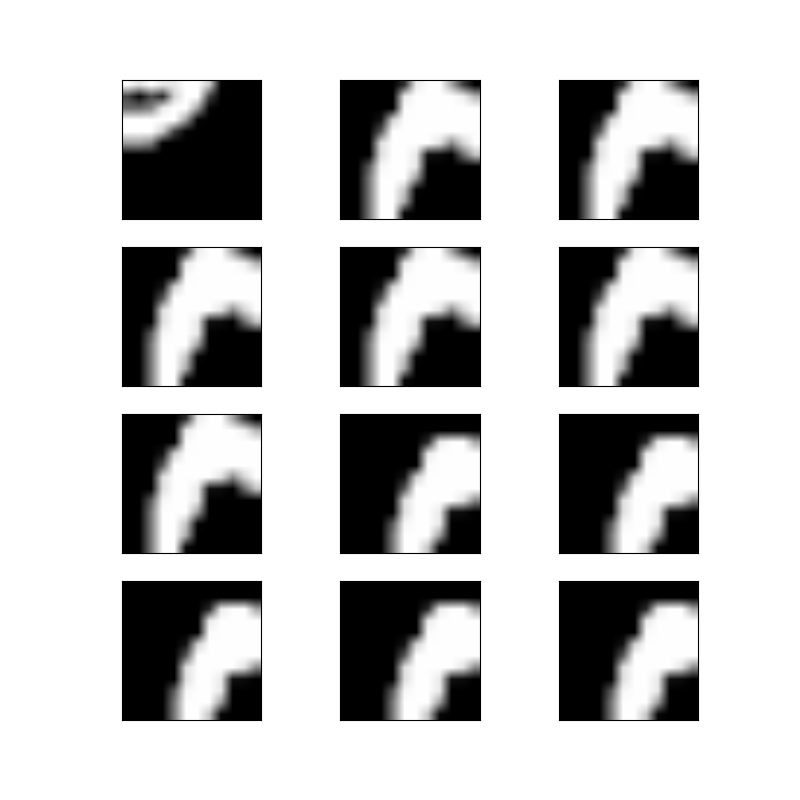

In [19]:
# Filter 5

fig = plt.figure()
H_filter = H[:,:,:,2]
H_sorted = np.argsort(H_filter,axis=None)
max12 = H_sorted[0:12]

for j in range(12):
    index = np.unravel_index(max12[j], H_filter.shape)
    im = mnist.test.images[index[0]].reshape(28,28)
    im = im[index[1]*2:index[1]*2+12,index[1]*2:index[1]*2+12]
    ax = fig.add_subplot(4, 3, j + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(im, cmap='Greys_r') 

Experimenting with different strides and parameters:

In [24]:
def weight_variable2(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable2(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


x = tf.placeholder(tf.float32, shape=[None, 784])
# reshape x to a 4d tensor, 
# with the second and third dimensions corresponding to image width and height, 
# and the final dimension corresponding to the number of color channels.
y_ = tf.placeholder(tf.float32, shape=[None, 10])


# 1st conv layer
# 32 features for each 5x5 patch

W_conv1 = weight_variable2([5, 5, 1, 32])
b_conv1 = bias_variable2([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 2nd conv layer
# 64 features for each 5x5 patch

W_conv2 = weight_variable2([5, 5, 32, 64])
b_conv2 = bias_variable2([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely connected layer

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


# Dropout

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Read out layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


# We'll use the cross entropy loss function 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))

# And classification accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# And the Adam optimiser
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

sess = tf.Session()
with sess.as_default():
    sess.run(tf.initialize_all_variables())

    for i in range(2000):
        batch = mnist.train.next_batch(50)
        if i%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})




step 0, training accuracy 0.06
step 100, training accuracy 0.84
step 200, training accuracy 0.9
step 300, training accuracy 0.94
step 400, training accuracy 0.92
step 500, training accuracy 0.96
step 600, training accuracy 0.92
step 700, training accuracy 0.96
step 800, training accuracy 0.96
step 900, training accuracy 0.98
step 1000, training accuracy 0.98
step 1100, training accuracy 0.98
step 1200, training accuracy 0.98
step 1300, training accuracy 1
step 1400, training accuracy 0.92
step 1500, training accuracy 0.94
step 1600, training accuracy 0.96
step 1700, training accuracy 0.94
step 1800, training accuracy 0.94
step 1900, training accuracy 0.98


In [25]:
# Print accuracy on the test set
print ('Test accuracy: %g' % sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Test accuracy: 0.9798
